In [65]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [50]:
import pandas as pd
pd.set_option('display.max_columns',600)
pd.set_option('display.max_rows',600)

In [51]:
sequence_length = 4 # Length of input sentence 
batch_size = 1    
input_dim = 512
d_model = 512   # output of every singal word
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [52]:
x

tensor([[[ 0.1509, -0.9793,  0.3370,  ..., -0.3551, -0.5920,  1.3053],
         [ 0.8080, -0.3941,  0.2823,  ..., -0.4742,  1.5809, -1.0092],
         [ 0.3700,  0.3154, -0.3962,  ..., -0.9145,  0.1895,  0.6361],
         [ 0.5966, -1.5804, -1.2377,  ...,  0.6600, -0.9679, -1.3211]]])

In [53]:
print(x.shape)

torch.Size([1, 4, 512])


In [54]:
# 3 * d_model means 3*512 
# i.e 1*512 for query vector
# i.e 1*512 for key vector
# i.e 1*512 for value vector
qkv_layer = nn.Linear(input_dim , 3 * d_model)

In [55]:
qkv_layer

Linear(in_features=512, out_features=1536, bias=True)

In [56]:
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

In [57]:
qkv

tensor([[[ 0.6632, -0.3547,  0.3546,  ..., -0.4919,  0.1253, -0.2190],
         [ 0.0882,  0.2002,  0.9098,  ...,  0.3706,  0.0353,  0.2743],
         [-0.9234,  0.3683,  0.2741,  ...,  0.2144, -0.6818, -0.1159],
         [-0.3603,  0.1845,  0.6336,  ...,  0.1130, -0.4578, -0.0224]]],
       grad_fn=<ViewBackward0>)

Text(0.5, 1.0, 'qkv distribution')

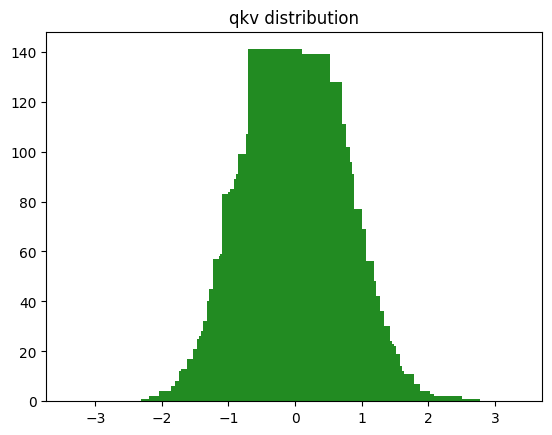

In [58]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [59]:
x_val.shape

(200,)

In [60]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [61]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [62]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [63]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

### Self Attention for multiple heads

$Self Attention = softmax(\frac{Q.K^T}{d_K} + M)$

In [66]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [67]:
k.T.shape

C:\Users\Asus\anaconda3\envs\torch2tf2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)
  """Entry point for launching an IPython kernel.


torch.Size([64, 4, 8, 1])

In [68]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-0.2622, -0.2975],
        [-0.1488,  1.4004],
        [-0.0092, -1.1228]])

In [69]:
torch.transpose(y, 1, 0)

tensor([[-0.2622, -0.2975],
        [-0.1488,  1.4004],
        [-0.0092, -1.1228]])

In [70]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [71]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [72]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [73]:
(scaled + mask)[0][0]

tensor([[-0.1979,    -inf,    -inf,    -inf],
        [ 0.0484, -0.3058,    -inf,    -inf],
        [-0.4551,  0.1119,  0.0514,    -inf],
        [-0.5281, -0.3503, -0.3107,  0.1177]], grad_fn=<SelectBackward0>)

In [74]:
scaled += mask

In [75]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [76]:
attention = F.softmax(scaled, dim=-1)

In [77]:
attention.shape

torch.Size([1, 8, 4, 4])

In [78]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5876, 0.4124, 0.0000, 0.0000],
        [0.2261, 0.3986, 0.3752, 0.0000],
        [0.1871, 0.2235, 0.2325, 0.3569]], grad_fn=<SelectBackward0>)

In [79]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

## Function

In [80]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [81]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [82]:
attention.shape

torch.Size([1, 8, 4, 4])

In [83]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5876, 0.4124, 0.0000, 0.0000],
        [0.2261, 0.3986, 0.3752, 0.0000],
        [0.1871, 0.2235, 0.2325, 0.3569]], grad_fn=<SelectBackward0>)

In [84]:
values.size()

torch.Size([1, 8, 4, 64])

In [85]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [86]:
linear_layer = nn.Linear(d_model, d_model)

In [87]:
out = linear_layer(values)

In [88]:
out.shape

torch.Size([1, 4, 512])

In [89]:
out

tensor([[[-0.0055,  0.0796, -0.0123,  ..., -0.1143, -0.0491,  0.1586],
         [ 0.0635, -0.0276, -0.1525,  ..., -0.3016, -0.0835, -0.1732],
         [ 0.0181, -0.0949, -0.3170,  ...,  0.1063, -0.6423, -0.2794],
         [ 0.0145, -0.3186, -0.4567,  ...,  0.5200,  0.0176, -0.1572]]],
       grad_fn=<ViewBackward0>)

### Class

In [90]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

### Input

In [91]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
